<a href="https://www.kaggle.com/code/dgluesen/measuring-pocket-stability?scriptVersionId=115932110" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#  Measuring the pocket stability to evaluate offensive and defensive line

*Dennis Gluesenkamp, Julian Wagner, Axel Demel, Samuel Lopez Santamaria*

*Imported from https://github.com/dgluesen/measuring_pocket_stability*

The pivotal point of the offensive play in a football team is primarily the quarterback. To be able to develop his passing game optimally, he needs a certain space around him in which he can act undisturbed and finally execute the throw, the pocket. In this protective area in the backfield, he should get as much time as possible from the offense's point of view, without being pressured and disturbed by the opposing defenders. The defense, on the other hand, tries to penetrate the protected area, i.e. to collapse the pocket, in order to disrupt the passing game as quickly and effectively as possible. Thus, the offensive line (O-line) and the defensive line (D-line) are important keys to a successful passing offense and defense, respectively.

In this notebook, we present an approach to measure pocket stability, thereby making the performance of O-line and D-line on a play-by-play basis comparable. It is an indicator for each team on how the performances of the specific lines are, also compared to the rest of the league. Our measurement of a pocket time is designed in an easily comprehensible dimension, namely seconds. This makes the measurement equally understandable and accessible to professionals, the media and the audience.

## Pocket stability and collapse

To measure the stability of the pocket, we first define at what point this stability is no longer guaranteed.

*__Definition:__ A pocket is collapsed when, after the snap, at least one D-line player has been able to get closer to the quarterback than any other O-line player is at that time.*

Based on this, we propose to measure how long on average the O-line can keep the pocket clean and how the individual times are statistically distributed. On the other hand, for the D-line it shows how good the defenders are to break through the opponents O-line. Therefore, we introduce the following metrics:
- **collapsed pocket**: A binary measure whether the pocket has collapsed or not in a specific play
- **pocket time**: The absolute time the pocket has stand in a specific play (until it collapsed, or the play ended)
- **expected pocket time**: The expected absolute time the pocket will stand in a specific play
- **time over/under expected pocket time**: The difference of the actual time the pocket has stand and the expected pocket time in a specific play

The *pocket time* is a rather simple evaluation and not suitable on a play-by-play basis, since it does not consider the quality of the opponent's line, the formation that is played and so on. Therefore, we introduce the *expected pocket time*, i.e. a Machine-Learning-model that estimates the expected time a pocket will stand in a specific play taking several external circumstances into account. Based on this expectation, we can measure for each play, how much the difference of actual and expected pocket time is (absolute and in percentage) which gives a play-by-play measure of O-line and D-line performances. 

### Example from the data

An example of the collapsed pocket measurement is shown below for frames 10, 25 and 40 of gameID 2021090900 and playID 97. In frame 10 we have the initial position with a clean pocket. In frame 25, the pocket is still quite clean after the snap, but it appears that the D-line on the right side from the quarterback could break through. In frame 40, the pocket has completely collapsed and three D-linemen have a clear path to the quarterback.

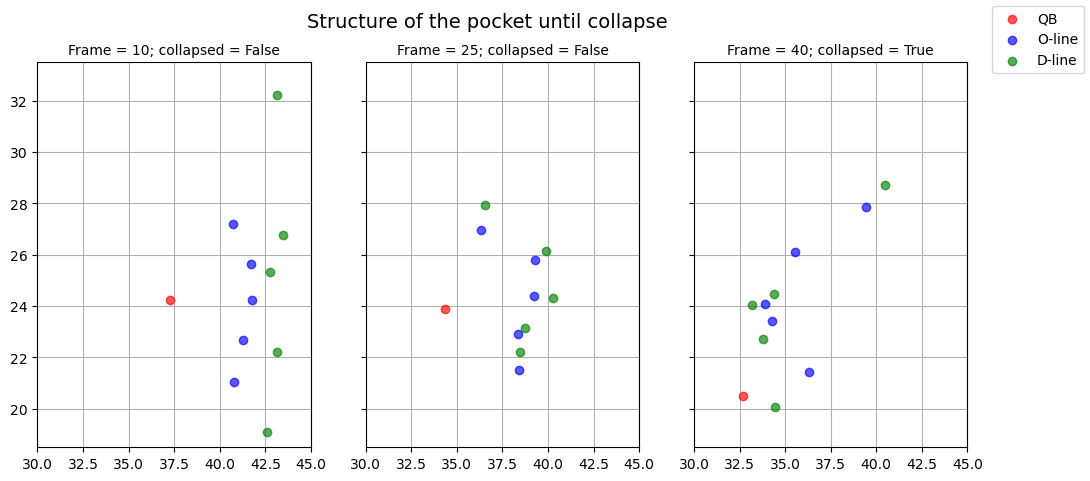

In [1]:
# example of the collapsing pocket measure for some frames
from src.visualization import get_pocket_visualization_data, visualize_pocket
data_example_play = get_pocket_visualization_data(week_index=0, game=2021090900, play=97)
visualize_pocket(df_play = data_example_play, frames=[10, 25, 40])

In this way, for each play, we evaluate whether or not the pocket collapsed and how long it stayed clean. We also calculate the total length of the play as a basis for comparison. Here we define the pocket time as the time from the snap to one of the following events:
* `autoevent_passforward`
* `pass_forward`
* `qb_sack`
* `qb_strip_sack`
* `run`

For the play time, for simplicity and lack of globally valid definitions, we stick with the time over all frames of the play. To be more precise here, we would need to define the start and end points of the relevant part of the play. For example, if a long pass reaches a receiver who then runs for many yards, the total play time after the released pass is no longer relevant for measuring. In the following table the corresponding calculated values for different play examples can be seen.

In [2]:
import pandas as pd
from src.config import PATH_POCKET_COLLAPSED
data_pocket_collapsed = pd.read_csv(PATH_POCKET_COLLAPSED)
print(data_pocket_collapsed.head(10))

       gameId  playId  pocket_collapsed  pocket_time  play_time oline dline

0  2021090900      97              True          3.4        4.2    TB   DAL

1  2021090900     137              True          2.9        3.6   DAL    TB

2  2021090900     187             False          3.0        3.0   DAL    TB

3  2021090900     282              True          3.5        4.2   DAL    TB

4  2021090900     349              True          2.3        3.6   DAL    TB

5  2021090900     410             False          2.6        2.6    TB   DAL

6  2021090900     434             False          2.7        2.7    TB   DAL

7  2021090900     456              True          3.2        3.5    TB   DAL

8  2021090900     480             False          4.4        4.4    TB   DAL

9  2021090900     509             False          3.7        3.7    TB   DAL


## Analysis of pocket stability

The information about how long a pocket remains clean, can be evaluated from the perspective of both offense and defense:
* For the O-Line, we can evaluate how often it maintains the pocket until the end of the game, or if the pocket collapses, how long it maintains the pocket before collapsing.
* For the D-Line, we can evaluate how often and how quickly the D-Line can collapse into the pocket.

The average of all teams thus also yields an expected value for the proportion of plays with held stability for the O-line and breakthroughs for the D-line. We show these values in the following table for all teams, as an example sorted from better to worse stability ratios.

In [3]:
from src.pocket_stability_measures import evaluate_pocket_stability
data_pocket_stability = evaluate_pocket_stability(data_pocket_collapsed=data_pocket_collapsed)
print(data_pocket_stability.sort_values(by=["oline_ps_perc"], ascending=False))

   team  oline_ps_perc  oline_above_avg  dline_pb_perc  dline_above_avg

11   SF        49.3151             True        57.3913            False

0    TB        49.1909             True        59.2593             True

5   PIT        49.1597             True        59.1093             True

16  TEN        46.9314             True        60.7595             True

20  CLE        46.5863             True        66.5385             True

25   GB        46.4602             True        55.5556            False

9   CIN        46.1240             True        58.6103            False

1   DAL        44.0613             True        58.2375            False

18  LAC        43.0657             True        65.6388             True

27  DEN        42.4658             True        54.1353            False

28  CHI        42.3387             True        54.1322            False

22   NE        41.9580             True        55.6738            False

19  WAS        41.9463             True        57.7

As an example, we would like to highlight the Tampa Bay Buccaneers. In 49.2% of the plays the O-line stood up to one of the ends defined above and kept the pocket clean. This is above the average. The same applies to the defense, which was able to break through 59.3% of the time, putting pressure on the quarterback. At the other end of the scale, the Seattle Seahawks can be cited as an example, with 34.8% for the O-line and 56.2% for the D-line, both below league expectations.

## Expected pocket time

However, the comparison with the league average is only a first approximation, since the expected time in a clean pocket also depends on other factors, which include, inter alia, formations, defenders in the box, and field position. These can have an impact on how a single play specifically develops, how much time the quarterback needs and then ultimately gets.

For this reason, using the features available in the provided dataset, we trained a simple random forest model that estimates the expected time in the pocket given these attributes. By doing so, we introduce a more detailed baseline to compare the pocket time.

In [4]:
from src.ml_model import evaluate_play
#data_pocket_collapsed[data_pocket_collapsed.gameId == 2021110100].playId
evaluate_play(play=79)

          gameId  playId  pocket_time oline dline  expected_pocket_time

8482  2021110100      79          2.6    KC   NYG              3.940452


As an example, we take the O-line of the Kansas City Chiefs in the game against the New York Giants. The model gives an expected pocket time of approximately 3.9s for the constellation from the play with the ID 79. The pocket time was 2.6s. However, we also note one of the remaining weaknesses of the metric. The above mentioned play of the Kansas City Chiefs consisted of a relatively free and successful pass from P. Mahomes to T. Kelce. For this reason, the pocket did not have to hold any longer because the pass had already been thrown. Nevertheless, the metric presented here provides a way to quantitatively measure the performance of both lines and compare it to an expected value.

## Summary and outlook

In this notebook, we introduced a metric applicable to both O-line and D-line, the pocket time. For this purpose, we defined the notion of a collapsing pocket and were able to report the fractions of collapses for both sides of the ball for the available data.

However, we see further potential for development beyond this. First, the necessary duration of a clean pocket needs to be defined in more detail. In this way, it would be possible in the future to compare the held time with the necessary time better than previously with the total time of the play. In a second point we would like to emphasize the potential that still needs to be exploited, including the evaluation of the pass result and the subgroups of successfully held versus collapsed pockets. Finally, we consider it promising to further optimize the machine learning model for determining the expected pocket time - not least under the previously mentioned improvements.